In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Define Dataset Path
data_path = r"F:\7th semester\Artifical Intelligence\Face Mask detection\data"
categories = ["with_mask", "without_mask"]

data = []
labels = []

# Loading images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        
        data.append(image)
        labels.append(category)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encoding labels: 'with_mask' -> 1, 'without_mask' -> 0
labels = np.where(labels == "with_mask", 0, 1)
labels = to_categorical(labels)

# Preprocessing input for MobileNetV2
data = preprocess_input(data)  # It will scale data between -1 and 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


In [4]:
# Load MobileNetV2 model without top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(2, activation="softmax")(x)

# Final Model
model = Model(inputs=base_model.input, outputs=predictions)


In [5]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [6]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Train the model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train)//32,
    epochs=20,
    verbose=1
)


C:\Users\Mani\.conda\envs\tfod310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6924 - loss: 0.6002 - val_accuracy: 0.9795 - val_loss: 0.1492
Epoch 2/20
  1/188 ━━━━━━━━━━━━━━━━━━━━ 2:28 795ms/step - accuracy: 0.9062 - loss: 0.2171

C:\Users\Mani\.conda\envs\tfod310\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 182ms/step - accuracy: 0.9062 - loss: 0.2171 - val_accuracy: 0.9788 - val_loss: 0.1482
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.9343 - loss: 0.1990 - val_accuracy: 0.9881 - val_loss: 0.0784
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.9375 - loss: 0.1767 - val_accuracy: 0.9881 - val_loss: 0.0781
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9608 - loss: 0.1304 - val_accuracy: 0.9874 - val_loss: 0.0582
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - accuracy: 1.0000 - loss: 0.0961 - val_accuracy: 0.9874 - val_loss: 0.0581
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9642 - loss: 0.1031 - val_accuracy: 0.9881 - val_loss: 0.0453
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 1.0000 - loss: 0.0352 - val_accuracy: 0.9881 - val_loss: 0.0452
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9755 - loss: 0.0785 - val_accurac

In [7]:
# Save the model
model.save("mask_detector_model.h5")

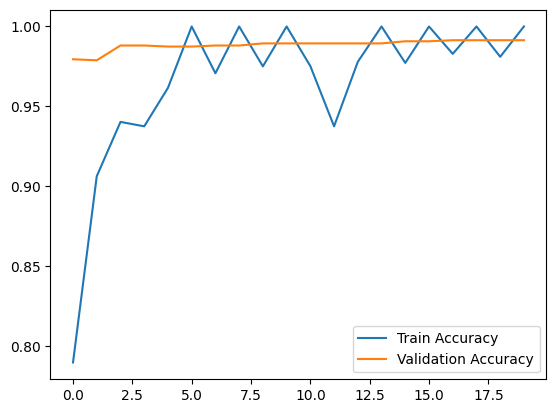

In [8]:
# Plot the accuracy and loss
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
# Load the saved model
from tensorflow.keras.models import load_model

model = load_model("mask_detector_model.h5")

# Load Haarcascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start webcam
# for live video detection in real time
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=4)
    
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        
        (mask, withoutMask) = model.predict(face)[0]
        
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
        cv2.putText(frame, label, (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        
    cv2.imshow("Face Mask Detection", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12